In [ ]:
#pip install -U layoutparser

In [ ]:
#pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

In [ ]:
#pip install layoutparser[ocr]     

In [1]:
# !git clone https://github.com/Layout-Parser/layout-parser.git

Cloning into 'layout-parser'...
remote: Enumerating objects: 1357, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 1357 (delta 324), reused 261 (delta 257), pack-reused 975
Receiving objects: 100% (1357/1357), 62.86 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (737/737), done.


In [1]:
%cd layout-parser/

/home/lstm/Github/reuters_classify/PDF conversion/layout-parser


In [53]:
import cv2

# imagepath = "./examples/data/paper-image.jpg"
# imagepath = "./examples/data/image61_0.png"
imagepath = "./examples/data/image71_0.png"
# imagepath = "./examples/data/image1_0.png"
image = cv2.imread(imagepath)
# image = image[..., ::-1] 

In [54]:
# cv2.imread(imagepath)#[..., ::-1] 

/home/lstm/miniconda3/envs/pdf2html/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


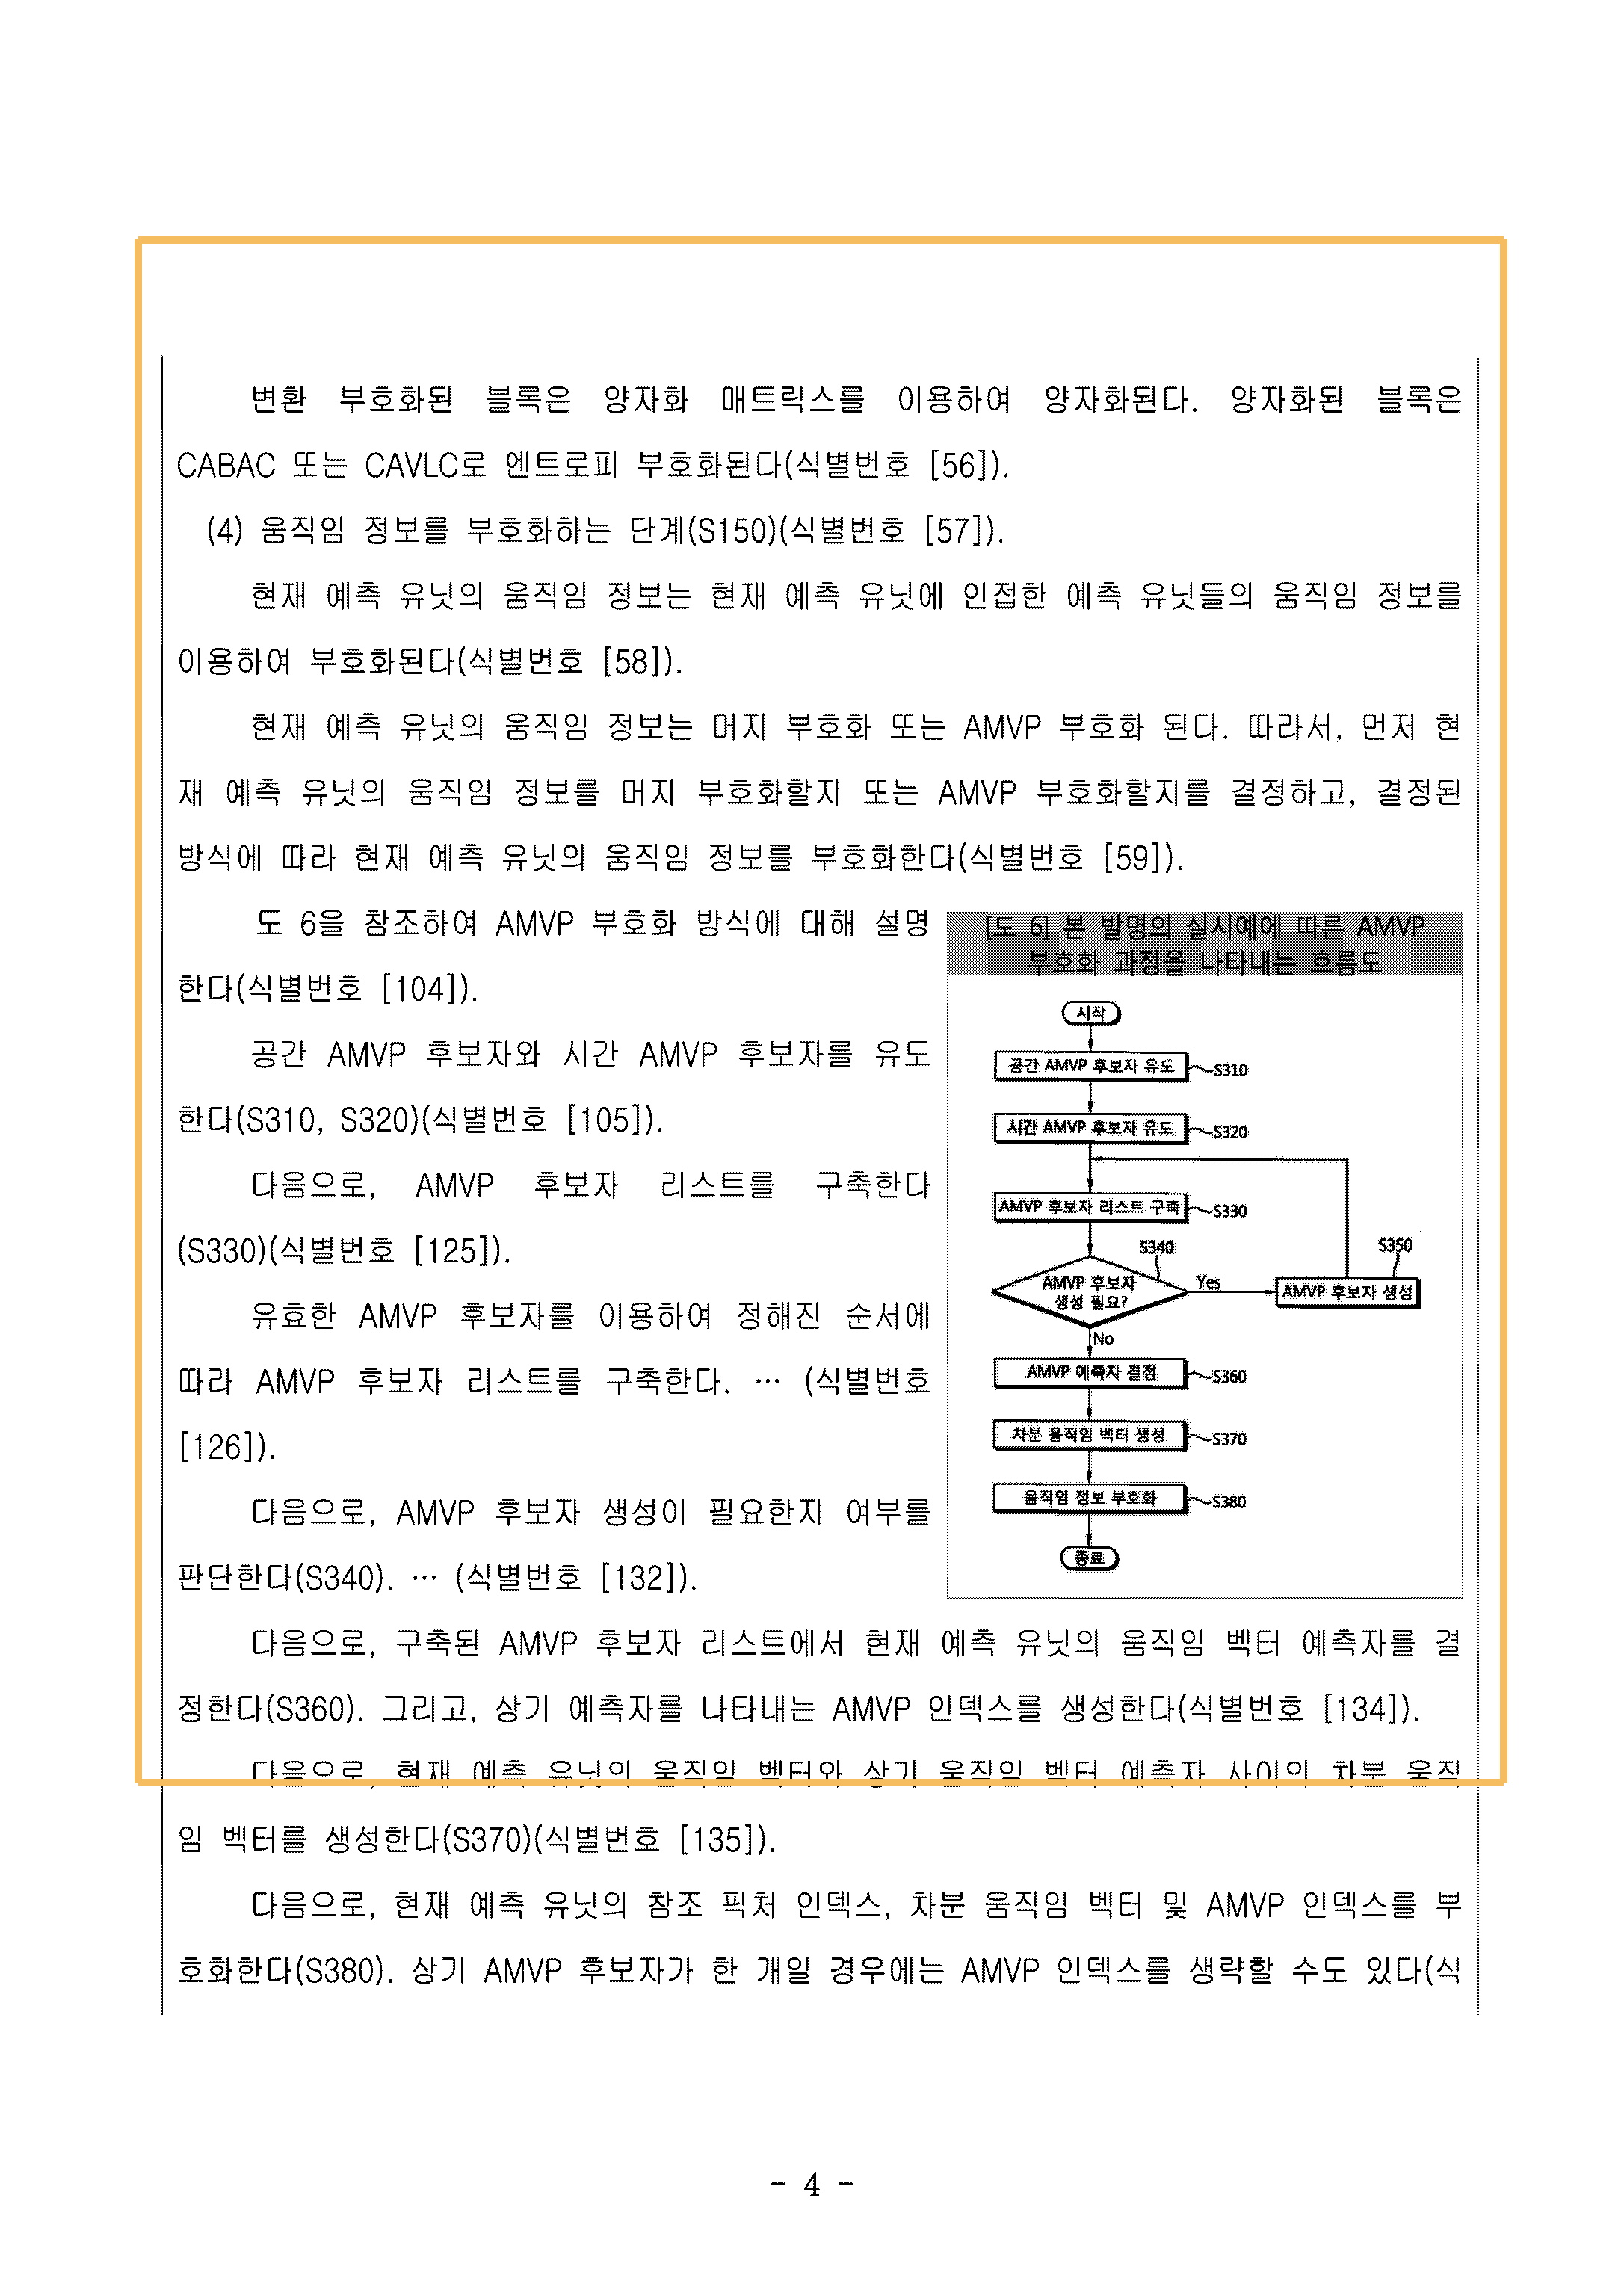

In [55]:
import layoutparser as lp
model = lp.Detectron2LayoutModel('lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config',extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.65],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})
layout = model.detect(image) 
lp.draw_box(image, layout,)

In [6]:
text_blocks = lp.Layout([b for b in layout if b.type=="Title"])
text_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=104.18389129638672, y_1=984.319091796875, x_2=441.509521484375, y_2=1011.4129638671875), text=None, id=None, type=Title, parent=None, next=None, score=0.987136960029602)], page_data={})

In [7]:
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [8]:
figure_blocks

Layout(_blocks=[TextBlock(block=Rectangle(x_1=72.32881164550781, y_1=152.18548583984375, x_2=1179.6295166015625, y_2=643.6031494140625), text=None, id=None, type=Figure, parent=None, next=None, score=0.9979682564735413)], page_data={})

In [9]:

text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [10]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1])

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

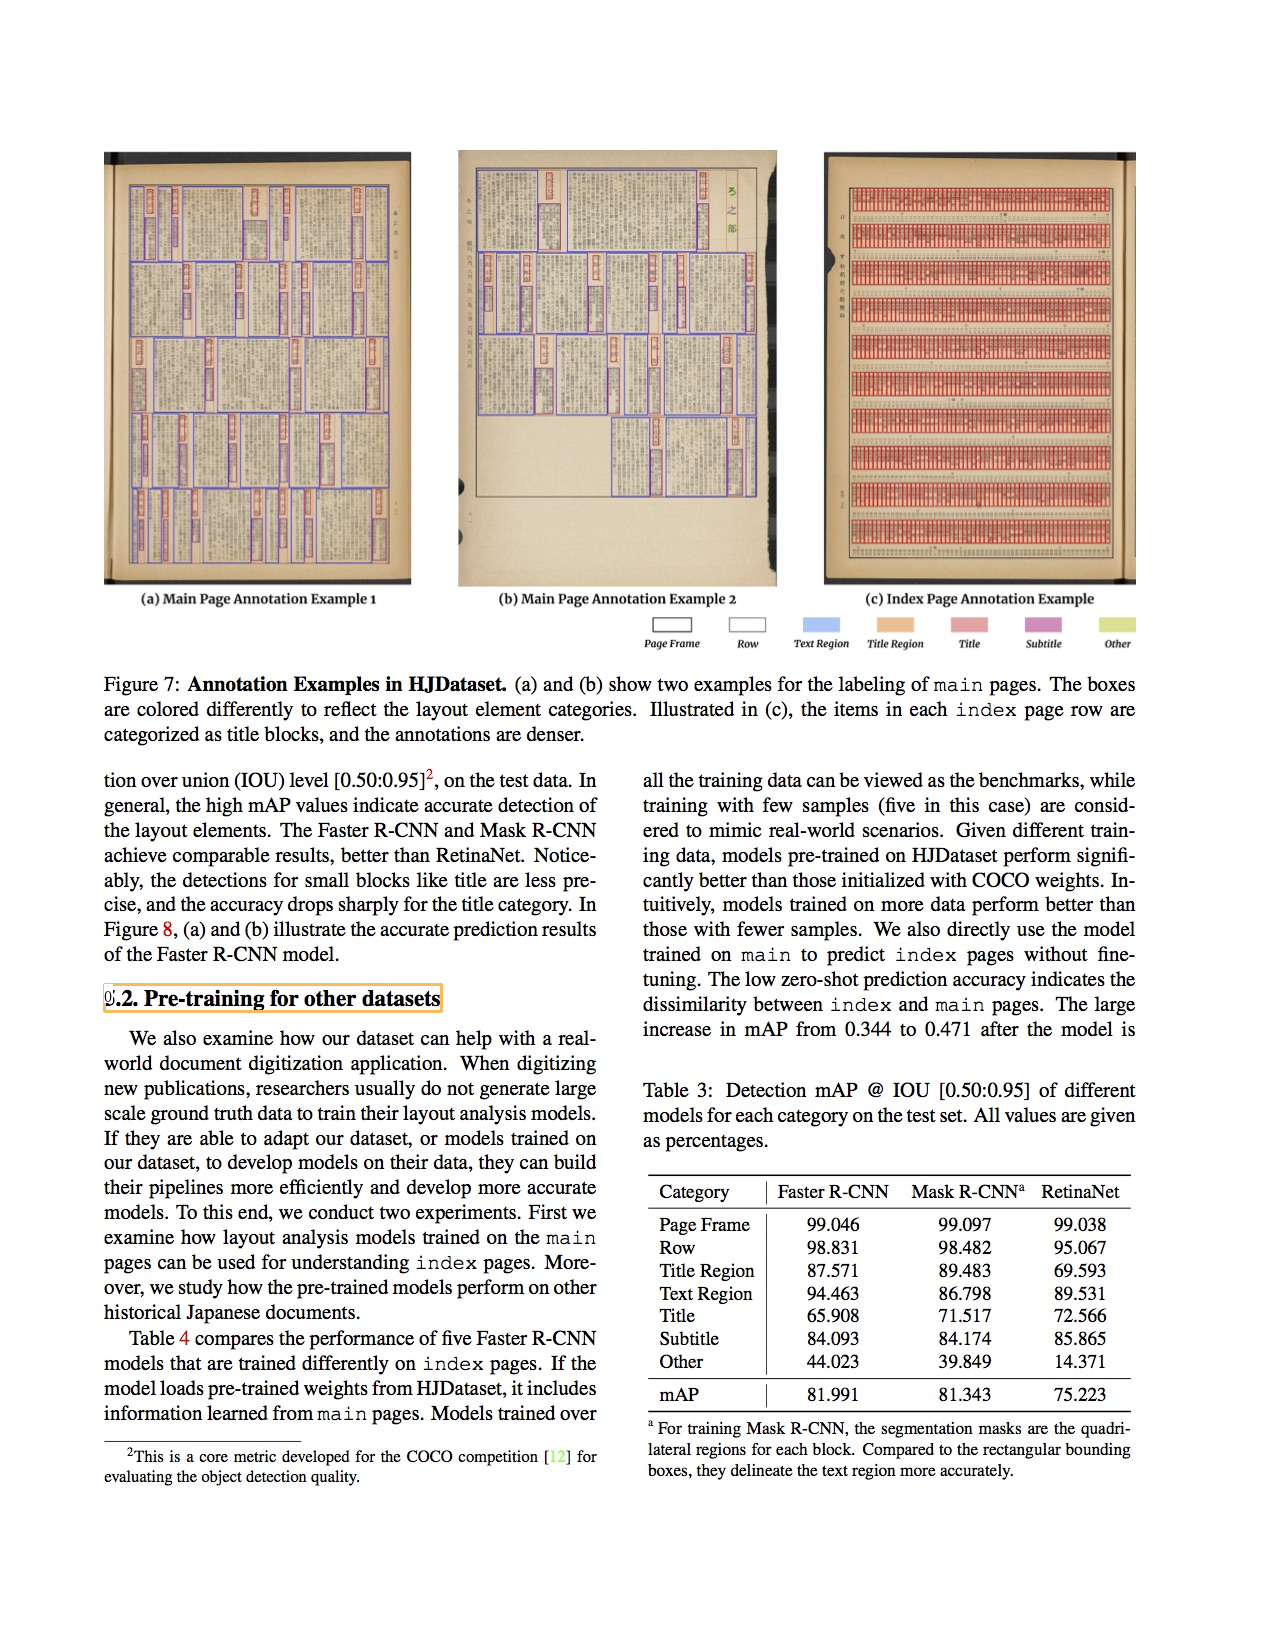

In [11]:

lp.draw_box(image, text_blocks,
            box_width=3, 
            show_element_id=True)

# using Teserract

In [26]:
ocr_agent = lp.TesseractAgent(languages='eng')     

In [27]:
for block in text_blocks:
    segment_image = (block
                       .pad(left=5, right=5, top=5, bottom=5)
                       .crop_image(image))
        # add padding in each image segment can help
        # improve robustness 
        
    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

In [28]:
text

'5.2. Pre-training for other datasets\n'

In [29]:
for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

5.2. Pre-training for other datasets

---


In [30]:
text_blocks.get_texts()

['5.2. Pre-training for other datasets\n']

In [31]:
for block in text_blocks:
  print(block)

TextBlock(block=Rectangle(x_1=104.18389129638672, y_1=984.319091796875, x_2=441.509521484375, y_2=1011.4129638671875), text=5.2. Pre-training for other datasets
, id=0, type=Title, parent=None, next=None, score=0.987136960029602)


# using GCV

In [ ]:
ocr_agent = lp.GCVAgent.with_credential("/home/lstm/.gcp/koreacaselaw-ffe91e33f191.json", languages = ['en', 'kr'])

In [ ]:
!pip install spacy

In [ ]:
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [ ]:
!pip install click==7.1.1

In [ ]:
import spacy
nlp = spacy.load("en_core_web_trf")


In [ ]:
sentence=["".join(txt) for txt in text_blocks.get_texts()]

In [ ]:
".".join(sentence)  

In [ ]:
doc = nlp(".".join(sentence))
for ent in doc.ents:
  print(ent.text,ent.label_)